In [2]:
import os
import textwrap

import matplotlib.pyplot as plt
import numpy as np
from functorch.dim import softmax
from PIL import Image

Empirical Coverage: 0.997169143665959


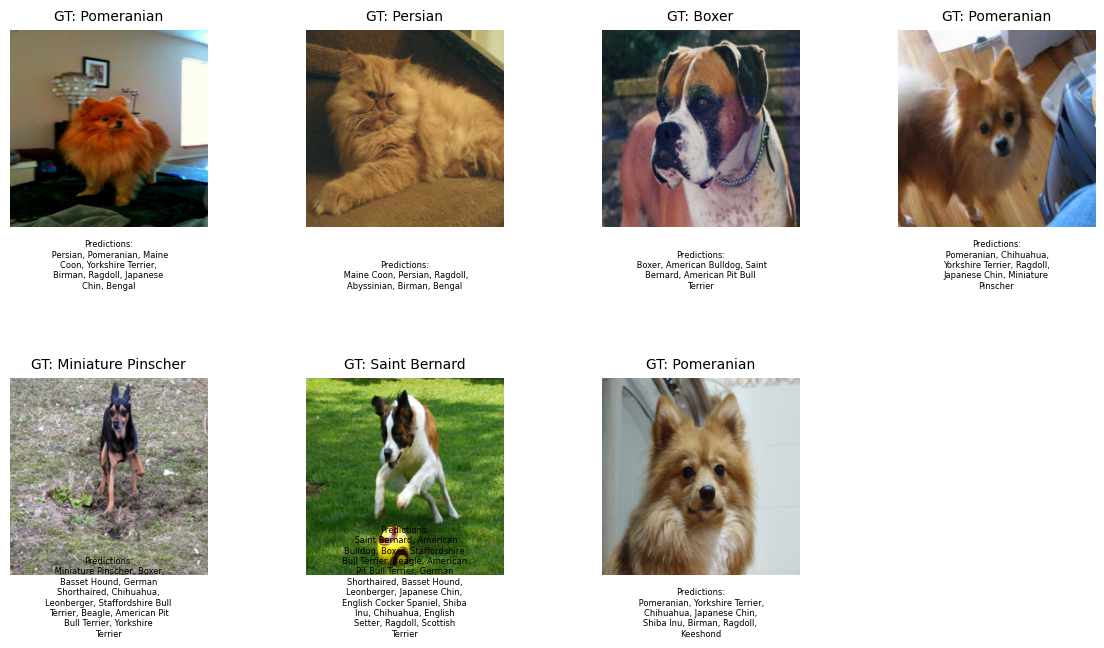

In [33]:
## Part 2 -- Use Adaptive Prediction 
# Data preparation
softmax_outputs = np.load('softmax_outputs.npy')
correct_classes = np.load('correct_classes.npy')

# Data Split
split = 2000
calibration_softmax = softmax_outputs[:split]
calibration_labels = correct_classes[:split]
validation_softmax = softmax_outputs[split:]
validation_labels = correct_classes[split:]

def calculate_scores(model_outputs, true_labels, gt_class=None):
    scores = []
    for i in range(len(model_outputs)):
        softmax_output = model_outputs[i]
        if gt_class is not None:
            true_class_prob = softmax_output[true_labels[gt_class[i]]]
        else:
            true_class_prob = softmax_output[true_labels[i]]
        sorted_probs = np.sort(softmax_output)[::-1]
        cumulative_sum = np.cumsum(sorted_probs)
        k = np.argmax(sorted_probs == true_class_prob)
        score = cumulative_sum[k]
        scores.append(score)
    return scores

def construct_adaptive_pred_set(softmax_output, q_hat):
    sorted_indices = np.argsort(softmax_output)[::-1]
    cumulative_sum = 0
    pred_set = []
    for idx in sorted_indices:
        cumulative_sum += softmax_output[idx]
        pred_set.append(idx)
        if cumulative_sum >= q_hat:
            break
    return pred_set

# Get coverage
alpha=0.5
calibration_scores = calculate_scores(calibration_softmax, calibration_labels)
q_hat = np.quantile(calibration_scores, 1-alpha)
cor_preds = 0
for i in range(len(validation_softmax)):
    pred_set = construct_adaptive_pred_set(validation_softmax[i], q_hat)
    if validation_labels[i] in pred_set:
        cor_preds += 1
empirical_coverage = cor_preds / len(validation_softmax)
print(f'Empirical Coverage: {empirical_coverage}')

# Get prediction from example images
folder_path = 'example_images'
example_outputs = np.load(os.path.join(folder_path, 'model_outputs.npy'))
gt_classes = np.load(os.path.join(folder_path, 'gt_classes.npy'))
idx2cls = np.load(os.path.join(folder_path, 'idx2cls.npy'), allow_pickle=True)
cls2idx = {v: k for k, v in enumerate(idx2cls)}

# Selected images and indices
selected_images = ['B0.png', 'B1.png', 'B2.png', 'B3.png', 'B15.png', 'B17.png', 'B19.png']
selected_indices = [0, 1, 2, 3, 15, 17, 19]

example_scores = calculate_scores(example_outputs, cls2idx, gt_classes)
q_hat = np.quantile(example_scores, 1-alpha)

# Plot
plt.figure(figsize=(14, 8))
for i, (idx, image_name) in enumerate(zip(selected_indices, selected_images)):
    softmax_output = example_outputs[idx]
    true_class = gt_classes[idx]
    image = Image.open(os.path.join(folder_path, image_name))
    pred_set = construct_adaptive_pred_set(softmax_output, q_hat)
    pred_class_names = [idx2cls[idx] for idx in pred_set]
    pred_texts = ', '.join(pred_class_names)
    wrapped_pred_texts = '\n'.join(textwrap.wrap(pred_texts, 30))
    
    ax = plt.subplot(2, 4, i+1)
    ax.imshow(image)
    ax.axis('off')
    plt.text(0.5, 1.05, f'GT: {true_class}', fontsize=10, ha='center', wrap=True, transform=plt.gca().transAxes)
    plt.text(0.5, -0.3, f'Predictions:\n {wrapped_pred_texts}', fontsize=6, ha='center', wrap=True, transform=plt.gca().transAxes)
    
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()
# 